# LSTM

## Requirements
- python 3.7
- keras
- tensorflow
- scikit-learn
- matplotlib
- seaborn
- pandas
- numpy
- wandb

## Imports

In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

import wandb
from wandb.keras import WandbCallback

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout, TimeDistributed, RepeatVector, GRU
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

# wandb.init(project="smartgrid-lstm-open")

Using TensorFlow backend.
wandb: WARNING Keras version 2.3.1 is not fully supported. Required keras >= 2.4.0


## Methods

In [2]:
def to_supervised(train, n_input, n_output=8):
    X, y = list(),list()
    
    X_start = 0
    
    # iterate over train dataset
    for _ in range(len(train)):
        
        # set the ranges for input + output
        X_end = X_start + n_input
        y_end = X_end + n_output
        
        # check if data contains enough samples for sequence
        if y_end <= len(train):
            X.append(train[X_start:X_end, :])
            y.append(train[X_end:y_end, 0])
            
        X_start += 1
    return np.array(X), np.array(y)

def build_model(data, n_input, params):
    
    # data preperation
    train, val = data
    X_train, y_train = to_supervised(train, n_input)
    X_val, y_val = to_supervised(val, n_input)
    
    # meta / parameters
    epochs, batch_size, verbose, learning_rate = params
    n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
    
    # reshape output
    y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
    y_val = y_val.reshape((y_val.shape[0], y_val.shape[1], 1))
    
    model = Sequential()
    model.add(GRU(256, activation='tanh', input_shape=(n_timesteps, n_features), kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(RepeatVector(n_outputs))
    model.add(GRU(256, activation='tanh', return_sequences=True))
    model.add(GRU(256, activation='tanh', return_sequences=True))
    model.add(TimeDistributed(Dense(128, activation='tanh')))
    model.add(TimeDistributed(Dense(1)))
    opt = Adam(learning_rate=learning_rate, clipvalue=0.5)
    model.compile(loss='mse', optimizer=opt)
    checkpoint = ModelCheckpoint("modelcheckpoint.hdf5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=50)

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_data=(X_val, y_val), callbacks=[checkpoint], shuffle=False)
    
    #model.save(os.path.join(wandb.run.dir, "model.h5"))
    
    # plot the model
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    
    return model

def forecast(model, history, n_input):
    data = np.array(history)
    X = data[-n_input:, :]
    X = X.reshape((1, X.shape[0], X.shape[1]))
    yhat = model.predict(X, verbose=0)
    yhat = yhat[0]
    return yhat



def visualize_forecast(history, validation, future, pred, future_pred, n_input, n_forecasts):
    if n_input > 48:
        past = history[-48:-n_forecasts+1]
    else:   
        past = history[-n_input:-n_forecasts+1]
    
    future = future[-n_forecasts:]
    validation = validation[-n_forecasts:]

    validation.index = validation.index + pd.Timedelta(n_forecasts, unit='h')
    future.index = future.index + pd.Timedelta(n_forecasts, unit='h')

    future['Prediction'] = future_pred
    validation['Prediction'] = pred
    validation['Actual'] = history[-8:]['Global_active_power']

    
    sns.set(rc={'figure.figsize':(14,5)})
    sns.lineplot(data=past, x=past.index, y="Global_active_power")
    sns.lineplot(data=validation, x=validation.index, y="Actual", color="lime")
    sns.lineplot(data=validation, x=validation.index, y="Prediction", color="red")
    sns.lineplot(data=future, x=future.index, y="Prediction", color="darkred")
    plt.legend(['Active Power (Past)','Active Power (Actual)','Active Power (Prediction)', 'Active Power (Future Prediction)'])

    plt.title('Predictions of Global Active Power')
    plt.xlabel('Timeline')
    plt.ylabel('Global Active Power')
    plt.grid(which='major', color="#ffffff", alpha=.5)
    plt.axvline(x=past.index[-1], color="green", linestyle="--")
    plt.axvline(x=validation.index[-1], color="green", linestyle="--")

## Data Analysis / Preperation

In [3]:
df = pd.read_csv('data/household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

df_resample = pd.DataFrame(columns=df.columns)

# global_active_power: household global minute-averaged active power (in kilowatt)
# global_reactive_power: household global minute-averaged reactive power (in kilowatt)
# voltage: minute-averaged voltage (in volt)
# global_intensity: household global minute-averaged current intensity (in ampere)

# df_resample['Global_active_power'] = np.cumsum(df['Global_active_power'].resample('h').mean())
# df_resample['Global_reactive_power'] = np.cumsum(df['Global_reactive_power'].resample('h').mean())
df_resample['Global_active_power'] = df['Global_active_power'].resample('h').mean()
df_resample['Global_reactive_power'] = df['Global_reactive_power'].resample('h').mean()
df_resample['Voltage'] = df['Voltage'].resample('h').mean()
df_resample['Global_intensity'] = df['Global_intensity'].resample('h').mean()

# sub_metering_#: energy sub-metering No. # (in watt-hour of active energy).
df_resample['Sub_metering_1'] = df['Sub_metering_1'].resample('h').sum()
df_resample['Sub_metering_2'] = df['Sub_metering_2'].resample('h').sum()
df_resample['Sub_metering_3'] = df['Sub_metering_3'].resample('h').sum()

columns = [x for x in df_resample.columns if x in ['Global_active_power']] 
df_resample = df_resample[columns]

df = df_resample

df_resample.head()

,Global_active_power
dt,
2006-12-16 17:00:00,4.222889
2006-12-16 18:00:00,3.632200
2006-12-16 19:00:00,3.400233
2006-12-16 20:00:00,3.268567
2006-12-16 21:00:00,3.056467


In [4]:
# Fill NaN's with column's mean value
for j in range(0,len(df_resample.columns)):        
        df_resample.iloc[:,j]=df_resample.iloc[:,j].fillna(df_resample.iloc[:,j].mean())

## Model building

In [5]:
# no. hours to forecast
n_forecasts = 8

# determines how much data is used to forecast
n_input = n_forecasts * 24

# determines if the data will be scaled
use_scaled = False




In [6]:
df_future = df[-n_input:]
df_pred = df[-(n_input+n_forecasts):-n_forecasts]
df_resample = df[:-n_forecasts*2]

if use_scaled:
    df_columns = df_resample.columns
    scaler = MinMaxScaler()
    df_pred_scaled = scaler.fit_transform(df_pred)
    df_future_scaled = scaler.fit_transform(df_future)
    train, test = train_test_split(scaler.fit_transform(df_resample), test_size=.2, shuffle=False, stratify=None)
else:
    train, test = train_test_split(df_resample.values, test_size=.2, shuffle=False, stratify=None)

In [ ]:
# determines whether we're going to train or evaluate an existing model
training = True

if training:
    data = [train, test]

    # params = [epochs, batch_size, verbose, learning_rate]
    params = [2000, 1700, 1, 0.00001]

    model = build_model(data, n_input, params)
else:
    model = load_model('modelcheckpoint.hdf5')

Train on 27459 samples, validate on 6716 samples
Epoch 1/2000
27459/27459 [==============================] - 5s 199us/step - loss: 4.6176 - val_loss: 3.9633
Epoch 2/2000
27459/27459 [==============================] - 5s 168us/step - loss: 4.4183 - val_loss: 3.8079
Epoch 3/2000
27459/27459 [==============================] - 5s 167us/step - loss: 4.2381 - val_loss: 3.6688
Epoch 4/2000
27459/27459 [==============================] - 5s 171us/step - loss: 4.0785 - val_loss: 3.5449
Epoch 5/2000
27459/27459 [==============================] - 5s 176us/step - loss: 3.9389 - val_loss: 3.4375
Epoch 6/2000
27459/27459 [==============================] - 5s 185us/step - loss: 3.8222 - val_loss: 3.3495
Epoch 7/2000
27459/27459 [==============================] - 5s 170us/step - loss: 3.7316 - val_loss: 3.2833
Epoch 8/2000
27459/27459 [==============================] - 5s 179us/step - loss: 3.6673 - val_loss: 3.2370
Epoch 9/2000
27459/27459 [==============================] - 5s 170us/step - loss: 3.623

## Forecasting & Visualizing

C:\Users\moham\anaconda3\envs\ztdl-updated\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\moham\anaconda3\envs\ztdl-updated\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\moham\anaconda3\envs\ztdl-updated\lib\site-packages\ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pan

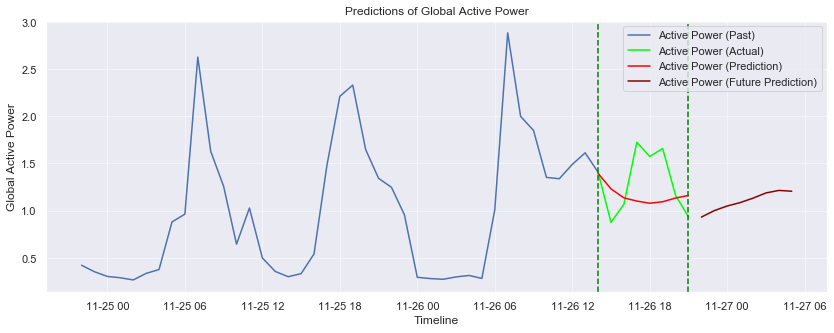

In [10]:
if use_scaled:
    # only works when using univariate input
    # TODO: add multivariate solution
    pred = scaler.inverse_transform(forecast(model, df_pred_scaled, n_input))
    future_pred = scaler.inverse_transform(forecast(model, df_future_scaled, n_input))

    visualize_forecast(df, df_pred, df_future, pred, future_pred, n_input, n_forecasts)
else:
    pred = forecast(model, df_pred, n_input)
    future_pred = forecast(model, df_future, n_input)
    
    # Prepare dataframes for plotting
    visualize_forecast(df, df_pred, df_future, pred, future_pred, n_input, n_forecasts)
